In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit


import sys
# sys.path.append("/Users/Work/Developer/interpretDL/interprettensor")
root_logdir = "./tf_logs"

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
tf.__version__

In [ ]:
# Helper Functions

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

######### Taken from sklearn #######
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=[10,10])
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def get1hot(y_train,y_test):
    from sklearn.preprocessing import OneHotEncoder

    enc = OneHotEncoder(categories="auto", sparse=False)
    y_train_1hot = enc.fit_transform([[label] for label in y_train]) # Since the function expects an array of "features" per sample
    y_test_1hot = enc.fit_transform([[label] for label in y_test])

    return y_train_1hot, y_test_1hot

def get_split(features, labels):
    
    # The train set will have equal amounts of each target class
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(features, labels):
        X_train = features[train_index]
        y_train = labels.iloc[train_index]
        X_test = features[test_index]
        y_test = labels.iloc[test_index]
        
        yield X_train, y_train, X_test, y_test

def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(18,6))
    
    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')
    
    plt.show()
    

def remove_label(features, labels, label="MCI"):
    labels = pd.Series(fused_labels)
    non_samples = labels != label

    stripped_features = features[non_samples]
    stripped_labels = labels[non_samples]

    return stripped_features, stripped_labels


In [ ]:
# FLAGS

DROP_MCI = True # Whether to drop MCI samples or not

### Getting data from csv

In [ ]:
filename = "ICV_ADNI.csv"
raw_data = pd.read_csv(filename)
print(raw_data.info())
raw_data.head()

In [ ]:
label_col = "DX_bl"
features = raw_data.drop(columns=["PTID", "scandate", "ICV",label_col])
raw_labels = raw_data[label_col].copy()
ICVs = raw_data["ICV"].copy()
features.head()

In [ ]:
# Getting all the columns related to surface area
thickness_features = [x for x in features.columns if "SA" in x ]

# Removing SA to reduce feature dimensions
raw_features = features.drop(columns=thickness_features)

raw_features.info()

> ### TODO: Compare LRP with and w/o ICV

In [ ]:
# # Normalize by ICV
# features_icv_normed = raw_features.div(np.power(ICVs, 1/3), axis = "rows")
# features_icv_normed.head()

## Using SMOTE

> Generates interpolated samples to balance training data 

In [ ]:
def balance_data(X,y):
    sm = SMOTE(random_state=42)
    
    features, labels = sm.fit_resample(X, y)
    
    print("Original: ", X.shape)
    print("After Data Augmentation: ", features.shape)
    
    return features, labels

## Fusing all the columns

In [ ]:
# Mapping to convert labels
fuse_maps = {"SMC": "CN", "EMCI":"MCI", "LMCI":"MCI"}

# Lambda fucntion to be used with Map func
fuse = lambda x: fuse_maps[x] if x in fuse_maps else x
dist = lambda x: pd.Series(x).value_counts()/len(x)

fused_labels = pd.Series(list(map(fuse, raw_labels)))

print("Sample Size:", len(fused_labels))
print("Original:\n", dist(raw_labels))
print()
print("Fused:\n", dist(fused_labels))

## Getting rid of MCI samples
> Only learning CN vs AD

In [ ]:
features, labels = remove_label(raw_features, fused_labels) if DROP_MCI else (raw_features, fused_labels)
print("Sample Size:", len(labels))
# print(labels)
dist(labels)

In [ ]:
# labels.reshape(-1,1)

### Get 1 Hot Vector representation of the *fused* categorical labels

In [ ]:
# Converting labels to 1-Hot Vectors
from sklearn.preprocessing import OneHotEncoder

hot_encoder = OneHotEncoder(categories="auto", sparse=False)
hot_encoder.fit(labels.values.reshape(-1,1)) # Since the function expects an array of "features" per sample

print("Categories:", hot_encoder.categories_)
hot_encoder.transform(labels[:5].values.reshape(-1,1))


## Normalizing training inputs

Does not work at all without normalization. The ranges for surface area and thickness are vastly different.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #x-u/sd
features = scaler.fit_transform(features) # Note that features is no longer a dataframe

## Initial Split for Sanity Check

In [ ]:
# Get split returns a generator
# List comprehension is one way to evaluate a generator
X_train, y_train, X_test, y_test = list(get_split(features, labels))[0]
print("Train Size:", X_train.shape)
print("Test Size:", y_test.shape)
# y_train

### Building the network

We will build a fully connected (slightly) deep network with no drop outs or batch normalization for now

In [ ]:
from keras import optimizers
from keras import regularizers

def exp_decay(epoch):
    initial_lr = 0.01
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
    print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_labels=3):
    keras.backend.clear_session()
    reset_graph()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1_l2(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 150, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 100, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=50, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
    nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=exp_decay(0),momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

num_features = X_train.shape[1]
num_labels = len(hot_encoder.categories_[0])
dnn = build_dnn(num_features, num_labels)
dnn.summary()

In [ ]:
def train_model(model, X, y, X_test=[], y_test=[], epochs=30, batch_size=20, verbose=1, plot=True):
    
    X_train,y_train = balance_data(X,y) # Both are np arrays now
    
    y_train = hot_encoder.transform(y_train.reshape(-1,1))
    y_test = hot_encoder.transform(y_test.values.reshape(-1,1))
    
    lr_scheduler = keras.callbacks.LearningRateScheduler(exp_decay)
    
    callback_list = []
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, validation_data=(X_test, y_test),
                       callbacks=callback_list, verbose=verbose)
    
    if plot: plot_history(history)
    
    return history
    

New Learning Rate: 0.01
Original:  (69, 148)
After Data Augmentation:  (90, 148)
Train on 90 samples, validate on 7 samples
Epoch 1/200
90/90 [==============================] - 0s 4ms/step - loss: 12.1711 - acc: 0.5444 - val_loss: 11.9016 - val_acc: 0.4286
Epoch 2/200
90/90 [==============================] - 0s 158us/step - loss: 11.2277 - acc: 0.7000 - val_loss: 10.6554 - val_acc: 0.4286
Epoch 3/200
90/90 [==============================] - 0s 139us/step - loss: 10.7166 - acc: 0.8333 - val_loss: 11.9380 - val_acc: 0.5714
Epoch 4/200
90/90 [==============================] - 0s 175us/step - loss: 10.3373 - acc: 0.8889 - val_loss: 10.3702 - val_acc: 0.5714
Epoch 5/200
90/90 [==============================] - 0s 172us/step - loss: 10.3632 - acc: 0.8222 - val_loss: 12.6462 - val_acc: 0.7143
Epoch 6/200
90/90 [==============================] - 0s 201us/step - loss: 9.8378 - acc: 0.8889 - val_loss: 8.9739 - val_acc: 1.0000
Epoch 7/200
90/90 [==============================] - 0s 199us/step - l

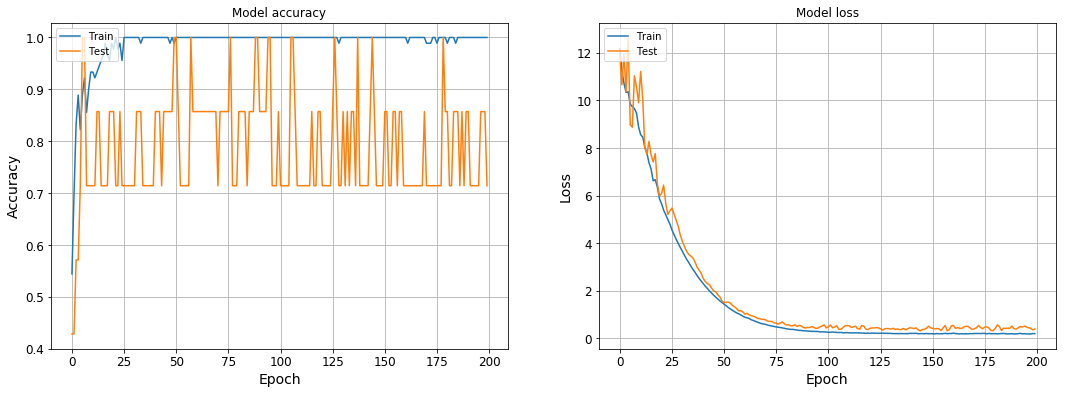

In [226]:
dnn = build_dnn(num_features, num_labels)
history = train_model(dnn, X_train, y_train, X_test, y_test, epochs=200, batch_size=10)

> AD vs CN

loss: 3.4295 - acc: 0.8846 - val_loss: 3.9303 - val_acc: 0.8125 - w/ ICV
val_acc = 0.875 -w/o ICV

### Calculating a confusion matrix

In [ ]:
def make_confusion(model, X_test, y_test):
    y_pred_probs = dnn.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(hot_encoder.transform(y_test.values.reshape(-1,1)), axis=1)
    plot_confusion_matrix(y_true, y_pred, classes=hot_encoder.categories_[0])
make_confusion(dnn, X_test, y_test)

In [ ]:
hot_encoder.categories_[0]

In [ ]:
loss_and_metrics = dnn.evaluate(features, labels_1hot)
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

In [ ]:
features.shape

## Using K=10 Fold Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold as KFold


def getKF(X,y, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42 ) #Default = 10

    for train_index, test_index in kf.split(X,y):
        X_train = X[train_index]
        y_train = y.iloc[train_index]
        X_test = X[test_index]
        y_test = y.iloc[test_index]
        
        yield X_train, y_train, X_test, y_test, test_index

histories = []
testing_indxs =[]
predictions = []
true_labels = []
zoo = []
for X_train, y_train, X_test, y_test, test_index in getKF(features, labels):
    print(test_index)
    dnn = build_dnn(num_features, num_labels)
    history = train_model(dnn,X_train, y_train, X_test, y_test, verbose=0, plot=False, epochs=200, batch_size=10)
    
    # Updating all information arrays
    histories.append(history)
    testing_indxs.append(test_index)
    zoo.append(dnn)
    
    y_pred_probs = dnn.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(hot_encoder.transform(y_test.values.reshape(-1,1)), axis=1)
    
    predictions.extend(y_pred)
    true_labels.extend(y_true)
    
    print(history.history["acc"][-1], history.history["val_acc"][-1])

In [ ]:
plot_confusion_matrix(predictions, true_labels, classes=hot_encoder.categories_[0])

In [ ]:
plot_confusion_matrix(predictions, true_labels, classes=hot_encoder.categories_[0], normalize = True)

In [ ]:
fig, axs = plt.subplots(len(histories)//2,2, figsize=(20,20))
axs=axs.flatten()
dfs = []

for i,history in enumerate(histories):
    df = pd.DataFrame(history.history)
    dfs.append(df)
    df[["acc","val_acc"]].plot(ax=axs[i])

In [ ]:
val_accs = [df["val_acc"].iloc[-1] for df in dfs]
print("Average:",np.mean(val_accs))
plt.bar(x=range(10),height=val_accs)
# plt.scatter(x=range(10), y=np.mean(val_accs))
plt.xlabel("Fold Number")
plt.ylabel("Acc")
plt.title("Accuracies for Each Fold")
val_accs

In [ ]:
testing_indxs

# Evaluating on non SMOTE Samples

In [ ]:
# def get_correct_predictions(model,X,y):

model = dnn

samples = features

# hot_enc = OneHotEncoder(categories="auto", sparse=False)
sample_labels = hot_encoder.transform([[label] for label in labels])
print("Categories:", hot_encoder.categories_)

predictions = model.predict(samples)
preds = np.array([np.argmax(x) for x in predictions])
true_labels = np.array([np.argmax(x) for x in sample_labels])
correct = preds == true_labels

AD_Sample = true_labels == 0

correct_preds = preds[correct]
correct_preds.shape

In [ ]:
loss_and_metrics = model.evaluate(samples[correct], sample_labels[correct])
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

# LRP

In [ ]:
import innvestigate
import innvestigate.utils as iutils


def perform_analysis(model, analyzer, data, labels):
    analysis = analyzer.analyze(data)
    prediction = model.predict(data)
    
#     header = "{:^30} {} {}".format("Relevances","Pred", "Actual")
#     print(header)
    
#     for rel,pred,actual in zip(analysis,prediction, labels):
# #         print(np.argmax(pred), actual)
#         result = "{} {:d} {:d}".format(np.around(rel,4), np.argmax(pred), np.argmax(actual))
#         print(result)
    df_anal = pd.DataFrame(analysis)
#     print()
#     print(df_anal.describe())
    return df_anal

# Selecting a DNN
test_dnn = dnn

# Stripping the softmax activation from the model
model_wo_sm = iutils.keras.graph.model_wo_softmax(test_dnn)

# Creating an analyzer
gradient_analyzer = innvestigate.analyzer.Gradient(model_wo_sm)
lrp = innvestigate.create_analyzer("lrp.z", model_wo_sm)


# Getting population to analyze
# Select samples with correct prediction
test_idx = correct & AD_Sample    
test_samples = samples[test_idx] 
test_labels = sample_labels[test_idx]

AD_lrp = perform_analysis(dnn,lrp,test_samples, test_labels)

test_idx = correct & (~AD_Sample)    
test_samples = samples[test_idx] 
test_labels = sample_labels[test_idx]

# perform_analysis(nn,gradient_analyzer,flowers,types)
CN_lrp = perform_analysis(dnn,lrp,test_samples, test_labels)


test_idx = correct
all_samples = samples[test_idx] 
all_labels = sample_labels[test_idx]

# perform_analysis(nn,gradient_analyzer,flowers,types)
ALL_lrp = perform_analysis(dnn,lrp, all_samples, all_labels)

In [ ]:
print(AD_lrp.shape)
print(CN_lrp.shape)
print(ALL_lrp.shape)


In [ ]:
population = lrp_results.mean()
population.plot()

In [ ]:
sorted_features = population.sort_values(ascending=False)
best_features = sorted_features[:6]

In [ ]:
best_features.index

In [ ]:
# abs(lrp_results)[best_features.index].hist(figsize=(20,20))

In [ ]:
raw_features.columns[best_features.index]

In [ ]:
sorted_features.plot(kind="bar", figsize=[30,15])
plt.xticks(rotation=65, fontsize="small")

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pos_only = ALL_lrp.copy()
pos_only[pos_only < 0] = 0
pca.fit(pos_only)

In [ ]:
print("Variance: ", pca.explained_variance_ratio_)
# pca.components_

In [ ]:
X = pca.transform(pos_only)
df = pd.DataFrame(X, columns=["PC1","PC2"])
_labels = np.array([np.argmax(x) for x in all_labels])
df.info()

In [ ]:
df.plot.scatter(x="PC1", y="PC2", s= 30, c=_labels, colormap='winter', figsize=(20,10))
# plt.legend(["AD", "CN"])
print("Categories:", hot_encoder.categories_)

In [ ]:

df["Type"] = 11
df2 = pd.DataFrame(X, columns=["PC1","PC2"])

In [ ]:
# # pd.concat([df,df2*500], axis=0)
# all_labels